In [1]:
# Select MAGs to search for CAZymes with HMM of dbCAN database
import pandas as pd
import numpy as np
from Bio import SeqIO
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Bio import Phylo
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from scipy import stats

In [2]:
#make sure this is bacterial only
representative_hgm_mags = pd.read_csv('~/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv')

#Import metadata for HGM MAGs
HGM_species = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_species_info_23790.tsv', sep='\t')
HGM_genomes = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_genome_info_206581.tsv', sep='\t')

bac_species = HGM_species[HGM_species['gtdb_taxonomy'].str.contains('d__Bacteria')]['species_id'].tolist()
bac_mags = HGM_genomes[HGM_genomes['species_id'].isin(bac_species)]['genome_id'].unique().tolist()

#Add phylum and family for each OTU
phylist = []
famlist = []

for tax in HGM_species['gtdb_taxonomy']:
    if len(tax.split(';')) > 1:
        phylist.append(tax.split(';')[1].replace('p__',''))
    else:
         phylist.append('NA')
    
    if len(tax.split(';')) > 4:
            famlist.append(tax.split(';')[4].replace('f__',''))
    else:
        famlist.append('NA')
            
HGM_species['Phylum'] = phylist
HGM_species['Family'] = famlist

phycoldict = {'Firmicutes': 'red', 
 'Actinobacteria': 'green', 
 'Bacteroidetes': 'blue', 
 'Proteobacteria': 'orange',
       'Verrucomicrobia': 'lightgreen', 
 'Desulfobacteraeota_A': 'lightblue', 
 'Cyanobacteria': 'gray',
       'Fusobacteria': 'purple', 
 'Spirochaetes': 'yellow', 
 'Elusimicrobia': 'pink',
'Epsilonbacteraeota': 'brown'}

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Order families by tree
#tree_nwk = pd.read_csv('~/20210519_signalp_analysis/gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile', sep=',', header=None).transpose()
mag_fam_attr = pd.read_csv('~/20210519_signalp_analysis/ipynb_out/genomeid_fam_attr.tsv', sep='\t')

tree_nwk = pd.read_csv('/home/ec2-user/20210519_signalp_analysis/20210609_gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile', sep=',', header=None).transpose()
#[string.replace('(','').replace(')','').split(':') 
mag_order = []
for string in tree_nwk[0]:
    for parsed in string.replace('(','').replace(')','').split(':'):
        if parsed in mag_fam_attr['genome_id'].tolist():
            mag_order.append(parsed)
            
reordered_index_list = []
for mag in mag_order:
    #reordered_index_list.append("f__" + mag_fam_attr[mag_fam_attr['genome_id'] == mag]['family'].tolist()[0])
    reordered_index_list.append(mag_fam_attr[mag_fam_attr['genome_id'] == mag]['family'].tolist()[0])
    
#Make a dictionary for family colors (each phylum is a different color)
col_dict = dict()
phylist = []
for fam in reordered_index_list:
    #sel = HGM_species[HGM_species['gtdb_taxonomy'].str.contains(fam)]
    sel = HGM_species[HGM_species['Family'] == fam]
    phy = set([tax.split(";")[1] for tax in  sel['gtdb_taxonomy']])
    if len(phy) == 1:
        phylist.append(list(phy)[0].replace('p__',''))
        col_dict[fam] = phycoldict[list(phy)[0].replace('p__','')]
        
col_colors = pd.Series(phylist).map(phycoldict)

In [4]:
#Break down by phyla

def sum_lists_itemwise(list1,list2):
    list3 = []
    ind = 0
    for item in list1:
        list3.append(item + list2[ind])
        ind = ind + 1
    return(list3)

def count_ec_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each COG category
    cog_counts_dict = dict()
    for cogcat in eggnog_output_sel['EC'].fillna('None'):
        #if cogcat != 'None' and len(cogcat) > 0:
        #    list_of_cats = [char for char in cogcat]
        #else:
        #    list_of_cats = [cogcat]
        list_of_cats = cogcat.split(',')
        
        for cat in list_of_cats:
            if cat in cog_counts_dict.keys():
                cog_counts_dict[cat] = cog_counts_dict[cat] + 1
            else:
                cog_counts_dict[cat] = 1
    return(cog_counts_dict)

def count_cazyme_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each cazyme category
    cazyme_counts_dict = dict()
    for cazymecat in eggnog_output_sel['CAZy'].fillna('None'):
        list_of_cats = cazymecat.split(',')
        for cat in list_of_cats:
            if cat in cazyme_counts_dict.keys():
                cazyme_counts_dict[cat] = cazyme_counts_dict[cat] + 1
            else:
                cazyme_counts_dict[cat] = 1

    return(cazyme_counts_dict)

In [5]:
eggnog_output = pd.read_csv('/home/ec2-user/20221005_metasecretome_notebooks/20221012_MM_9ny4543y.emapper.annotations.tsv',
           skiprows=4, sep='\t', index_col=False, skipfooter=3).rename(columns={'#query':'query'})
eggnog_output['genome_id'] = ['_'.join(orfid.split('_')[:2]) for orfid in eggnog_output['query']]


/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [6]:
cazyme_counts_dict = count_cazyme_cats(eggnog_output)

cazyme_counts = pd.DataFrame(pd.Series(cazyme_counts_dict, name='counts')).sort_values('counts', ascending=True)['counts'][-21:-1]

#Filter eggNOG for CAZymes, then focus in on EC functions of CAZymes
combocazy_list = []
for cazy in eggnog_output['CAZy'].dropna():
    common_cazy = set(cazy.split(',')) & set(cazyme_counts.index.tolist())
    if len(common_cazy) > 0:
        combocazy_list.append(cazy)
        


In [7]:
ec2descriptor = {'3.2.1.177': 'Alpha-D-xyloside xylohydrolase',
 '3.2.1.37': 'Xylan 1,4-beta-xylosidase',
 '3.2.1.89': 'Arabinogalactan endo-beta-1,4-galactanase',
 '3.2.1.8': 'Endo-1,4-beta-xylanase',
 '3.2.1.65': 'Levanase',
 '3.2.1.80': 'Fructan beta-fructosidase',
 '3.2.1.45': 'Glucosylceramidase',
 '3.2.1.3': 'Glucan 1,4-alpha-glucosidase',
 '3.2.1.41': 'Pullulanase',
 '3.2.1.97': 'Endo-alpha-N-acetylgalactosaminidase',
 '3.2.1.99': 'Arabinan endo-1,5-alpha-L-arabinosidase',
 '3.2.1.55': 'Non-reducing end alpha-L-arabinofuranosidase',
 '3.2.1.18': 'Exo-alpha-sialidase',
 '3.2.1.14': 'Chitinase',
 '3.2.1.20': 'Alpha-glucosidase',
 '3.2.1.78': 'Mannan endo-1,4-beta-mannosidase',
 '3.2.1.1': 'Alpha-amylase',
 '3.2.1.21': 'Beta-glucosidase',
 '3.2.1.51': 'Alpha-L-fucosidase',
 '3.2.1.52': 'Beta-N-acetylhexosaminidase',
'3.1.2.12': 'S-formylglutathione hydrolase',
                '3.2.1.10': 'Oligo-1,6-glucosidase',
                '5.4.99.16': 'Maltose alpha-D-glucosyltransferase',
                '3.2.1.24': 'Alpha-mannosidase',
                '3.2.1.135': 'Neopullulanase',
                '3.2.1.4': 'Cellulase'}

In [8]:
eggnog_cazy_ec = eggnog_output[eggnog_output['CAZy'].isin(combocazy_list)].replace('-',np.nan).dropna(axis=0, subset=['EC'])
cazyme_ec_dict = count_ec_cats(eggnog_cazy_ec)

cazyme_ec_counts = pd.DataFrame(pd.Series(cazyme_ec_dict, name='counts')).sort_values('counts', ascending=True)['counts'][-21:-1]

cazymelabels = []
for cazyme in cazyme_ec_counts.index.tolist():
    cazymelabels.append(ec2descriptor[cazyme])


In [9]:
topEC_phy_orfid_counts = pd.DataFrame()
#Make stacked bar plot of top EC phyla distribution

#Add taxonomy info
EC_annot_orfids = eggnog_cazy_ec[['query','genome_id','EC']].dropna(subset=['EC'])
EC_annot_orfids_taxmeta = EC_annot_orfids.join(HGM_genomes.set_index('genome_id')[['repository','species_id']], 
                                               'genome_id').join(HGM_species.set_index('species_id')[['species_name',
                                                                                                      'gtdb_taxonomy']],'species_id')

for EC_query in cazyme_ec_counts.index.tolist(): #list(ec2descriptor.keys()):
    EC_group_concat = pd.DataFrame()

    for name, group in EC_annot_orfids_taxmeta.groupby('EC'):
        if EC_query in name.split(','):
            EC_group_concat = EC_group_concat.append(group)

    EC_group_concat.drop_duplicates('query')
    #Count unique orfids in each phylum that have this EC annotation
    EC_orfids = EC_group_concat.drop_duplicates('query')
    EC_orfids['Phylum'] = [tax.split(';')[1].replace('p__','') for tax in EC_orfids['gtdb_taxonomy']]
    EC_orfids['Phylum'].value_counts()
    topEC_phy_orfid_counts = topEC_phy_orfid_counts.append(pd.Series(EC_orfids['Phylum'].value_counts(), 
                                                                     name=ec2descriptor[EC_query]))
#Sort by phy with most ORFids total
topEC_phy_orfid_counts.fillna(0, inplace=True)
topEC_phy_orfid_counts = topEC_phy_orfid_counts.append(pd.Series(np.sum(topEC_phy_orfid_counts), name='Total')).sort_values(by=['Total'],axis=1, ascending=False).drop(['Total'], axis=0)

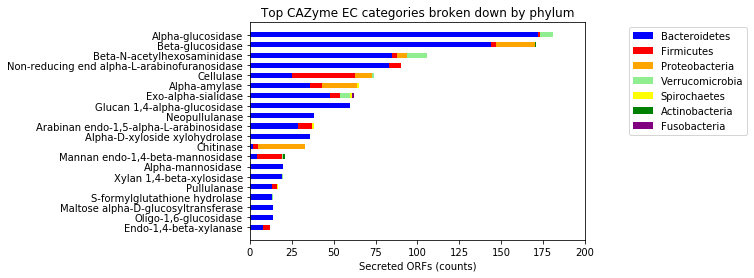

In [49]:
#Make stacked bar plot to show how much of the predicted metasecretome is from each phylum

labels = topEC_phy_orfid_counts.index.tolist()
height = 0.5

fig, ax = plt.subplots()

left_prevphy = 0
for phy in topEC_phy_orfid_counts.columns:
    orfcounts = topEC_phy_orfid_counts[phy].tolist()
    if left_prevphy == 0:
        ax.barh(labels, orfcounts, height, label=phy, color=phycoldict[phy])
        left_prevphy = orfcounts
    else:
        ax.barh(labels, orfcounts, height, label=phy, left=left_prevphy, color=phycoldict[phy])
        left_prevphy = sum_lists_itemwise(left_prevphy,orfcounts)
    
ax.set_xlim([0,200])
ax.legend()
ax.set_xlabel('Secreted ORFs (counts)')
ax.set_title('Top CAZyme EC categories broken down by phylum')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ipynb_out/Figures/Fig3_v1_topcazyec_perphy_barplot.svg',format='svg', bbox_inches="tight")

plt.show()

In [ ]:
! cat /home/ec2-user/20221005_hmmer_dbcan_HGM_representatives/parsed_hmmer_dbcan_output/*.out.dm.ps > ipynb_out/hmmer_dbcan_HGM_representatives_output.tsv

In [10]:
hmmscan_parser_names = ['target_name','target_len','query_name','query_len','e-value',
                        'target_start','target_end','query_start','query_end','coverage']
hmmer_dbcan_parser = pd.read_csv('ipynb_out/hmmer_dbcan_HGM_representatives_output.tsv', sep='\t', header=None,
           names=hmmscan_parser_names)

hmmer_dbcan_parser['genome_id'] = ['_'.join(orf.split('_')[:2]) for orf in hmmer_dbcan_parser['query_name']]

hmmer_dbcan_parser['cazyme_fam'] = [item.replace('.hmm','') for item in hmmer_dbcan_parser['target_name']]


In [11]:
hmmer_dbcan_parser_filtered = hmmer_dbcan_parser[(hmmer_dbcan_parser.coverage >= 0.35) & (hmmer_dbcan_parser['e-value'] <=10**-15)]

In [12]:
HGM_largecluster_orfs_secpred = pd.read_csv('ipynb_out/HGM_largecluster_orfs_secpred.tsv', sep='\t')
secreted_largecluster_orfs = HGM_largecluster_orfs_secpred[(HGM_largecluster_orfs_secpred['secreted'] == 'yes')].orfid.unique().tolist()

In [13]:
#Limit to large cluster ORFs because those were the only ones we ran through signalP
largeclusterorfs = HGM_largecluster_orfs_secpred.orfid.unique().tolist()
hmmer_dbcan_parser_filtered_largeclusterorfs = hmmer_dbcan_parser_filtered[hmmer_dbcan_parser_filtered.query_name.isin(largeclusterorfs)]

In [16]:
hmmer_dbcan_parser_filtered_largeclusterorfs.to_csv('suppl_tables/Supplementary_table_S2.tsv', sep='\t', header=True, index=True)

In [57]:
#How many ORFs were annotated as CAZymes?
hmmer_dbcan_parser_filtered_largeclusterorfs.query_name.unique().shape

(43331,)

In [56]:
#What percentage of ORFs annotated as CAZymes were predicted to be secreted?
total = hmmer_dbcan_parser_filtered_largeclusterorfs.query_name.unique().shape[0]
secreted = hmmer_dbcan_parser_filtered_largeclusterorfs[hmmer_dbcan_parser_filtered_largeclusterorfs.query_name.isin(secreted_largecluster_orfs)].query_name.unique().shape[0]
secreted/total*100

10.507488864785026

In [14]:
#Get orfids for sec or nonsec
def get_orfids():
    passing_HGM_largecluster_orfs_tax_df = pd.read_csv('ipynb_out/passing_HGM_largecluster_orfs_tax_df.tsv', sep='\t', index_col=0)
    sec_orfids = passing_HGM_largecluster_orfs_tax_df[passing_HGM_largecluster_orfs_tax_df['secreted'] == 'yes']['orfid'].unique().tolist()
    nonsec_orfids = passing_HGM_largecluster_orfs_tax_df[passing_HGM_largecluster_orfs_tax_df['secreted'] == 'no']['orfid'].unique().tolist()
    
    return(sec_orfids, nonsec_orfids)


In [15]:
sec_orfids, nonsec_orfids = get_orfids()

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [60]:
#Make dataframe differentiating secreted from non-secreted CAZymes
hmmer_dbcan_parser_filtered_largeclusterorfs['cazyme_fam_secstat'] = hmmer_dbcan_parser_filtered_largeclusterorfs['cazyme_fam'] + "_sec" + hmmer_dbcan_parser_filtered_largeclusterorfs['query_name'].isin(sec_orfids).astype(str)
hmmer_dbcan_parser_filtered_largeclusterorfs[['genome_id','query_name','cazyme_fam_secstat','e-value']].to_csv('ipynb_out/secstat_hmmer_orfid_df_v14.tsv', sep='\t')

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
#We then use this tsv in 20221012_cazotypes_nonbin_v10.R script to generate PCoA

In [69]:
hmmer_dbcan_parser_filtered_largeclusterorfs[:5]

,target_name,target_len,query_name,query_len,e-value,target_start,target_end,query_start,query_end,coverage,genome_id,cazyme_fam,cazyme_fam_secstat
58,GT4.hmm,160,ERS235498_12_k99_14644_4,407,6.200000e-28,12,151,230,365,0.868750,ERS235498_12,GT4,GT4_secFalse
59,GT4.hmm,160,ERS235498_12_k99_14644_7,379,2.800000e-24,7,140,201,332,0.831250,ERS235498_12,GT4,GT4_secFalse
60,GT26.hmm,171,ERS235498_12_k99_14644_8,251,6.300000e-63,2,171,56,229,0.988304,ERS235498_12,GT26,GT26_secFalse
62,GT28.hmm,157,ERS235498_12_k99_16570_4,373,4.400000e-27,2,152,207,354,0.955414,ERS235498_12,GT28,GT28_secFalse
90,GT2_Glycos_transf_2.hmm,170,ERS235498_12_k99_26830_23,361,1.800000e-36,1,168,4,163,0.982353,ERS235498_12,GT2_Glycos_transf_2,GT2_Glycos_transf_2_secFalse


In [16]:
#Limit to one result per query, based on lowest e-value
hmmer_dbcan_parser_1res = hmmer_dbcan_parser_filtered_largeclusterorfs.sort_values('e-value', ascending=True).drop_duplicates('query_name')

total_cazymes = dict()
perc_sec_cazymes = dict()
total_sec_cazymes = dict()

for name, group in hmmer_dbcan_parser_1res[['cazyme_fam','query_name','genome_id']].groupby('genome_id'):
    mag = name
    #Calculate number of ORFs in MAG that are annotated with CAZyme fams
    total_cazymes[mag] = group['query_name'].unique().shape[0]
    #Calculate percentage of secreted ORFs that are annotated as CAZymes in MAG
    sec_cazymes = group[group['query_name'].isin(sec_orfids)]['query_name'].unique().shape[0]
    total_sec_cazymes[mag] = sec_cazymes
    if total_cazymes[mag] == 0:
        perc_sec_cazymes[mag] = 0
    else:
        perc_sec_cazymes[mag] = sec_cazymes/total_cazymes[mag]*100

cazyme_stats_df = pd.DataFrame(pd.Series(perc_sec_cazymes, name='perc_sec_cazymes')).transpose().append(pd.Series(total_cazymes, 
                                    name='total_cazymes')).transpose()
cazyme_stats_df['total_sec_cazymes'] = pd.Series(total_sec_cazymes, name='total_sec_cazymes')


In [17]:
temp = cazyme_stats_df.join(HGM_genomes[['genome_id','species_id']].set_index('genome_id'))
phylum_cazyme_stats_df = temp.join(HGM_species[['species_id','Phylum','Family']].set_index('species_id'), 'species_id')[['perc_sec_cazymes','total_sec_cazymes','total_cazymes',
                                                                                      'Phylum','Family']]


In [18]:
phylum_cazyme_stats_df[:4]

,perc_sec_cazymes,total_sec_cazymes,total_cazymes,Phylum,Family
ERS235498_12,0.000000,0,11.0,Firmicutes,DTU089
ERS235502_46,0.000000,0,26.0,Firmicutes,CAG-138
ERS235506_6,0.000000,0,38.0,Actinobacteria,Coriobacteriaceae
ERS235518_14,1.886792,1,53.0,Firmicutes,DTU089


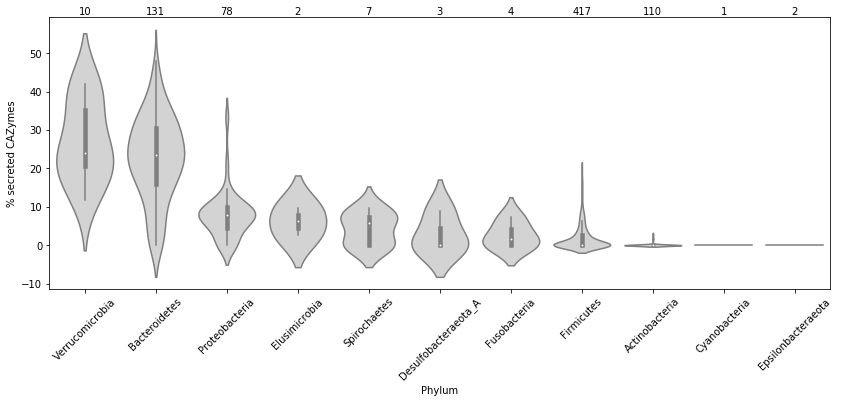

In [21]:
plt.subplots(figsize=[14, 5])

phy_mean = dict()
for name, group in phylum_cazyme_stats_df.groupby('Phylum'):
    phy_mean[name] = np.mean(group.perc_sec_cazymes)
    
orderbymean = pd.DataFrame(pd.Series(phy_mean, name='mean')).sort_values('mean', ascending=False).index.tolist()

#sns.swarmplot(x= 'Phylum', y = 'perc_sec_cazymes', data = phylum_cazyme_stats_df, color='k', alpha=0.5)
sns.violinplot(x= 'Phylum', y = 'perc_sec_cazymes', data = phylum_cazyme_stats_df, scale="width", order=orderbymean, color='lightgrey')

for phy in orderbymean:
    num_mags = phylum_cazyme_stats_df[phylum_cazyme_stats_df.Phylum == phy].shape[0]
    plt.text(orderbymean.index(phy), 60, str(num_mags), horizontalalignment='center', size='medium', color='black', weight='normal')

plt.xticks(rotation=45)
plt.ylabel('% secreted CAZymes')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ipynb_out/Figures/Fig3_v2_seccazy_perc_phy_violinplot.svg',format='svg')

plt.show()

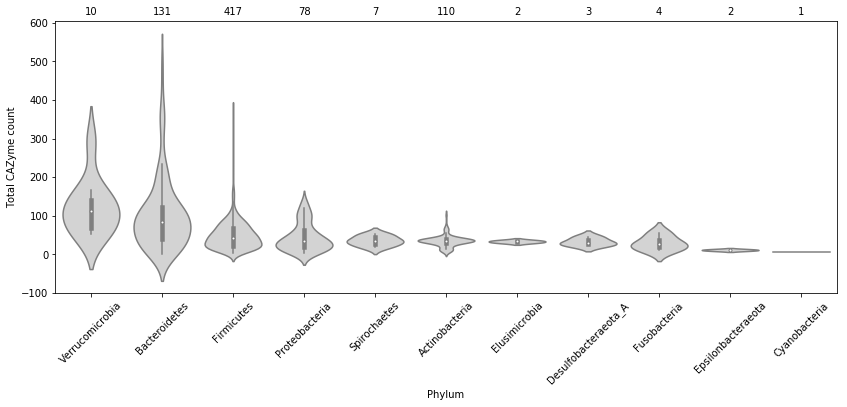

In [23]:
plt.subplots(figsize=[14, 5])

phy_mean = dict()
for name, group in phylum_cazyme_stats_df.groupby('Phylum'):
    phy_mean[name] = np.mean(group.total_cazymes)
    
orderbymean = pd.DataFrame(pd.Series(phy_mean, name='mean')).sort_values('mean', ascending=False).index.tolist()

#sns.swarmplot(x= 'Phylum', y = 'total_cazymes', data = phylum_cazyme_stats_df, color='k', alpha=0.5)
sns.violinplot(x= 'Phylum', y = 'total_cazymes', data = phylum_cazyme_stats_df, scale="width", order=orderbymean, color='lightgrey')

for phy in orderbymean:
    num_mags = phylum_cazyme_stats_df[phylum_cazyme_stats_df.Phylum == phy].shape[0]
    plt.text(orderbymean.index(phy), 620, str(num_mags), horizontalalignment='center', size='medium', color='black', weight='normal')


plt.xticks(rotation=45)
plt.ylabel('Total CAZyme count')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ipynb_out/Figures/Fig3_v2_seccazy_count_phy_violinplot.svg',format='svg')
plt.show()

In [57]:
def get_phylum(tax):
    if len(tax.split(';')) > 1:
        phylum = tax.split(';')[1].replace('p__','')
    else:
        phylum = 'NA'
    return(phylum)

def get_family(tax):
    if len(tax.split(';')) > 4:
        fam = tax.split(';')[4].replace('f__','')
    else:
        fam = 'NA'
    return(fam)

In [ ]:
HGM_taxinfo = HGM_genomes.set_index('genome_id').join(HGM_species.set_index('species_id'), 'species_id')
HGM_taxinfo['phylum'] = [get_phylum(tax) for tax in HGM_taxinfo['gtdb_taxonomy']]


In [58]:
GHs_of_interest = ['GH2','GH3','GH29']
animal_carb_ghs_enriched_in_bact = hmmer_dbcan_parser_filtered_largeclusterorfs[hmmer_dbcan_parser_filtered_largeclusterorfs.cazyme_fam.isin(GHs_of_interest)]
animal_carb_ghs_secreted_df = pd.DataFrame()
for name, group in animal_carb_ghs_enriched_in_bact.groupby('genome_id'):
    mag = name
    tax = HGM_taxinfo.loc[mag]
    gtdb = HGM_taxinfo.loc[mag]['gtdb_taxonomy']
    species = HGM_taxinfo.loc[mag]['species_name']
    number_of_animal_carb_ghs_secreted = len(set(group.query_name.unique()) & set(secreted_largecluster_orfs))
    #if number_of_animal_carb_ghs_secreted > 0:
    mag_dict = {'Family': get_family(gtdb),
               'Animal_carb_gh_count': number_of_animal_carb_ghs_secreted}
    animal_carb_ghs_secreted_df = animal_carb_ghs_secreted_df.append(pd.Series(mag_dict, name=mag))

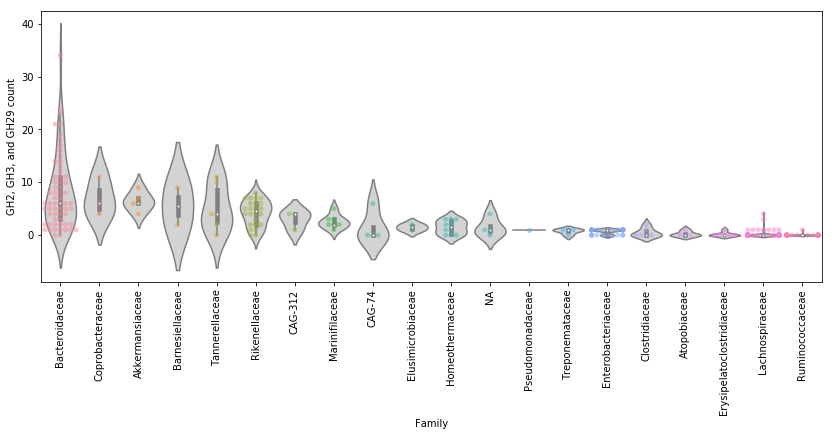

In [74]:
plt.subplots(figsize=[14, 5])

fam_mean = dict()
for name, group in animal_carb_ghs_secreted_df.groupby('Family'):
    mean = np.mean(group.Animal_carb_gh_count)
    fam_mean[name] = mean
    
mean_df = pd.DataFrame(pd.Series(fam_mean, name='mean'))
nonzero_means_df = mean_df[mean_df['mean'] > 0]
orderbymean = nonzero_means_df.sort_values('mean', ascending=False).index.tolist()

sns.swarmplot(x= 'Family', y = 'Animal_carb_gh_count', data = animal_carb_ghs_secreted_df, alpha=0.5,
             order=orderbymean)
sns.violinplot(x= 'Family', y = 'Animal_carb_gh_count', data = animal_carb_ghs_secreted_df, scale="width", order=orderbymean, color='lightgrey')
plt.xticks(rotation=90)
plt.ylabel('GH2, GH3, and GH29 count')
plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig('ipynb_out/Figures/Fig3_v1_seccazy_count_phy_violinplot.svg',format='svg')
plt.show()

In [95]:
GHs_of_interest = ['GH2','GH3','GH29', 'GH18', 'GH20', 'GH19', 'GH42', 'GH116', 'GH4', 'GH1', 'GH95', 'GH141', 'GH129',
                  'GH38', 'GH125', 'GH109', 'GH123', 'GH35', 'GH85', 'GH105', 'GH59', 'GH113', 'GH92', 'GH84',
                  'GH33', 'GH89', 'GH110', 'GH154', 'GH98', 'GH88', 'GH165', 'GH99', 'GH151', 'GH163', 'GH147', 'GH164',
                  'GH101', 'GH79']
animal_carb_ghs_enriched_in_bact = hmmer_dbcan_parser_filtered_largeclusterorfs[hmmer_dbcan_parser_filtered_largeclusterorfs.cazyme_fam.isin(GHs_of_interest)]
animal_carb_ghs_secreted_df = pd.DataFrame()
for name, group in animal_carb_ghs_enriched_in_bact.groupby('genome_id'):
    mag = name
    tax = HGM_taxinfo.loc[mag]
    gtdb = HGM_taxinfo.loc[mag]['gtdb_taxonomy']
    species = HGM_taxinfo.loc[mag]['species_name']
    number_of_animal_carb_ghs_secreted = len(set(group.query_name.unique()) & set(secreted_largecluster_orfs))
    #if number_of_animal_carb_ghs_secreted > 0:
    mag_dict = {'Family': get_family(gtdb),
               'Animal_carb_gh_count': number_of_animal_carb_ghs_secreted}
    animal_carb_ghs_secreted_df = animal_carb_ghs_secreted_df.append(pd.Series(mag_dict, name=mag))
    
# plt.subplots(figsize=[14, 5])


# sns.swarmplot(x= 'Family', y = 'Animal_carb_gh_count', data = animal_carb_ghs_secreted_df, alpha=0.5,
#              order=orderbymean)
# sns.violinplot(x= 'Family', y = 'Animal_carb_gh_count', data = animal_carb_ghs_secreted_df, scale="width", order=orderbymean, color='lightgrey')
# plt.xticks(rotation=90)
# plt.ylabel('GH2, GH3, and GH29 count')
# plt.rcParams['svg.fonttype'] = 'none'
# # plt.savefig('ipynb_out/Figures/Fig3_v1_seccazy_count_phy_violinplot.svg',format='svg')
# plt.show()

In [96]:
phycoldict = {'Firmicutes': 'red', 
 'Actinobacteria': 'green', 
 'Bacteroidetes': 'blue', 
 'Proteobacteria': 'orange',
       'Verrucomicrobia': 'lightgreen', 
 'Desulfobacteraeota_A': 'lightblue', 
 'Cyanobacteria': 'gray',
       'Fusobacteria': 'purple', 
 'Spirochaetes': 'yellow', 
 'Elusimicrobia': 'pink',
'Epsilonbacteraeota': 'brown'}

def fam2phy(family):
    phylum = HGM_taxinfo[HGM_taxinfo['Family'] == family].Phylum.unique()[0]
    return(phylum)

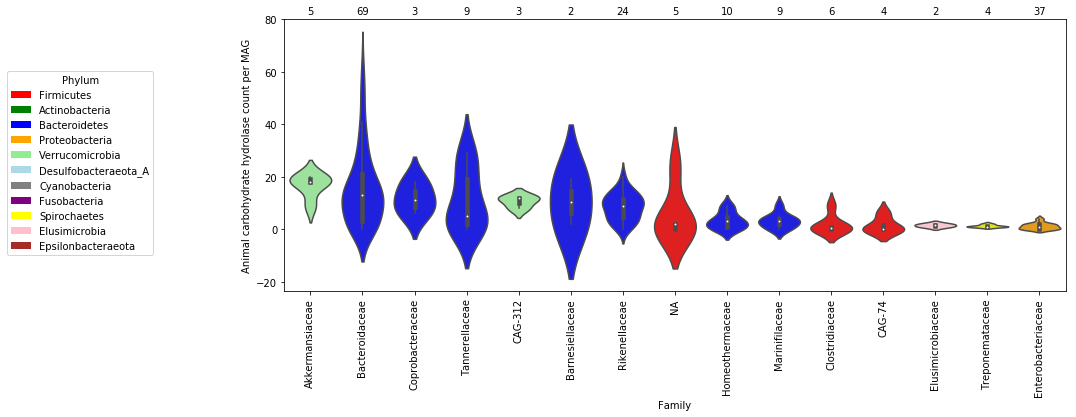

In [112]:
fam_mean = dict()
for name, group in animal_carb_ghs_secreted_df.groupby('Family'):
    mean = np.mean(group.Animal_carb_gh_count)
    fam_mean[name] = mean
    
mean_df = pd.DataFrame(pd.Series(fam_mean, name='mean'))
nonzero_means_df = mean_df[mean_df['mean'] > 1]
orderbymean = nonzero_means_df.sort_values('mean', ascending=False).index.tolist()

fam_phy_col_dict = dict()
for fam in orderbymean:
    phy = fam2phy(fam)
    fam_phy_col_dict[fam] = phycoldict[phy]
    
plt.subplots(figsize=[14, 5])
plt.rcParams['svg.fonttype'] = 'none'
#sns.swarmplot(x= 'Family', y = 'Animal_carb_gh_count', data = animal_carb_ghs_secreted_df, alpha=0.2, color='k',
#             order=orderbymean)
sns.violinplot(x= 'Family', y = 'Animal_carb_gh_count', data = animal_carb_ghs_secreted_df, scale="width", 
               order=orderbymean, color='lightgrey', palette=fam_phy_col_dict)
plt.xticks(rotation=90)
plt.ylabel('Animal carbohydrate hydrolase count per MAG')

for fam in orderbymean:
    #num_mags = animal_carb_ghs_secreted_df[animal_carb_ghs_secreted_df.Family == fam].shape[0]
    num_mags = animal_carb_ghs_secreted_df[animal_carb_ghs_secreted_df.Family == fam].index.unique().shape[0]
    plt.text(orderbymean.index(fam), 82, str(num_mags), horizontalalignment='center', size='medium', color='black', weight='normal')

handles = [mpatches.Patch(facecolor=phycoldict[name]) for name in phycoldict]
plt.legend(handles, phycoldict, title='Phylum',
          bbox_to_anchor=(0, 0.75), bbox_transform=plt.gcf().transFigure)#, loc='upper right')
#plt.savefig('ipynb_out/Figures/SupplFig3_v1_animalcarbcazy_count_phy_violinplot.svg',format='svg')
plt.show()